# 5. Classifier-Free Diffusion Guidance

So far, we have been able to train a model to generate images of clothing using the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. However, there is no way for the user to specify what kind of images should be generated. Let's fix that by using [Classifier-Free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf), a relatively simple way to create a [Conditional Diffusion Model](https://github.com/TeaPearce/Conditional_Diffusion_MNIST/tree/main).

#### Learning Objectives

The goals of this notebook are to:
* Add categorical embeddings to a U-Net
* Train a model with a Bernoulli mask
* Add a weight the reverse diffusion process
* Practice learnings on a more challenging dataset


#### References:
- [Conditional Diffusion Model - Github Repo](https://github.com/TeaPearce/Conditional_Diffusion_MNIST/tree/main)
-  [Classifier-Free Diffusion Guidance - Arxiv Paper](https://arxiv.org/pdf/2207.12598.pdf)
-  [FashionMNIST - Github Repo](https://github.com/zalandoresearch/fashion-mnist)

In [1]:
from pathlib import Path
import glob
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from torchvision.utils import save_image, make_grid
from IPython.display import Image as ImageDisplay

torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Notebook is running in: {device}")

# For saving some images or artifacts later
folder_path = Path("04_images")
folder_path.mkdir(exist_ok=True)

Notebook is running in: cuda


**Load fashionMNIST Dataset**

In [2]:
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./data/",
        download=True,
        train=train,
        transform=data_transform,
    )

def load_transformed_fashionMNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(), # Scale data into [0, 1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [3]:
IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.51MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 61.5MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.6MB/s]


## 5.1 Model Training

Our `B`eta schedule from before [03_Diffusion_Models.ipynb](./03_Diffusion_Models.ipynb) will stay the same.

In [4]:
class DDPM:
    def __init__(self, B, device):
        self.B = B
        self.T = len(B)
        self.device = device

        # Forward diffusion variables
        self.a = 1.0 - self.B
        self.a_bar = torch.cumprod(self.a, dim=0)
        self.sqrt_a_bar = torch.sqrt(self.a_bar)  # Mean Coefficient
        self.sqrt_one_minus_a_bar = torch.sqrt(1 - self.a_bar)  # St. Dev. Coefficient

        # Reverse diffusion variables
        self.sqrt_a_inv = torch.sqrt(1 / self.a)
        self.pred_noise_coeff = (1 - self.a) / torch.sqrt(1 - self.a_bar)

    def q(self, x_0, t):
        """
        The forward diffusion process
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        t = t.int()
        noise = torch.randn_like(x_0)
        sqrt_a_bar_t = self.sqrt_a_bar[t, None, None, None]
        sqrt_one_minus_a_bar_t = self.sqrt_one_minus_a_bar[t, None, None, None]

        x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
        return x_t, noise

    def get_loss(self, model, x_0, t, *model_args):
        x_noisy, noise = self.q(x_0, t)
        noise_pred = model(x_noisy, t, *model_args)
        return F.mse_loss(noise, noise_pred)

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        """
        The reverse diffusion process
        Returns the an image with the noise from time t removed and time t-1 added.
        model: the model used to remove the noise
        x_t: the noisy image at time t
        t: timestep
        model_args: additional arguments to pass to the model
        """
        t = t.int()
        pred_noise_coeff_t = self.pred_noise_coeff[t]
        sqrt_a_inv_t = self.sqrt_a_inv[t]
        u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
        if t[0] == 0:  # All t values should be the same
            return u_t  # Reverse diffusion complete!
        else:
            B_t = self.B[t - 1]  # Apply noise from the previos timestep
            new_noise = torch.randn_like(x_t)
            return u_t + torch.sqrt(B_t) * new_noise

    @torch.no_grad()
    def sample_images(self, model, img_ch, img_size, ncols, *model_args, axis_on=False):
        # Noise to generate images from
        x_t = torch.randn((1, img_ch, img_size, img_size), device=self.device)
        plt.figure(figsize=(8, 8))
        hidden_rows = self.T / ncols
        plot_number = 1

        # Go from T to 0 removing and adding noise until t = 0
        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=self.device).float()
            e_t = model(x_t, t, *model_args)  # Predicted noise
            x_t = self.reverse_q(x_t, t, e_t)
            if i % hidden_rows == 0:
                ax = plt.subplot(1, ncols+1, plot_number)
                if not axis_on:
                    ax.axis('off')
                show_tensor_image(x_t.detach().cpu())
                plot_number += 1
        plt.show()

In [5]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = DDPM(B, device)

This version of our `UNet` introduces several key updates. We’ve made some architectural adjustments and added new components to handle class-based conditioning.

In the `__init__` method, we now include an additional parameter, `c_embed_dim`. Similar to how we embed the timestep `t`, this allows us to create embeddings for class categories.

```python
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])  # New
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])  # New
```

In the `forward` function, we introduce two new inputs: `c` and `c_mask`.

* **`c`** represents the categorical conditioning vector, which can be a [one-hot encoding](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding) or a learned embedding.
* **`c_mask`** randomly zeros out portions of `c`, encouraging the model to learn how to generate outputs both with and without class information—similar to classifier-free guidance.

```python
        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)
```

There are multiple strategies to integrate these class embeddings into the U-Net. One effective technique is **scaling and shifting**, as described in [this paper](https://arxiv.org/pdf/2210.08823.pdf). Here, we scale (multiply) the categorical embedding with the latent features and add the time embedding as a shift. The scale acts like a learned variance, while the shift represents an adaptive mean.

```python
        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)  # Modified
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)  # Modified
        return self.out(torch.cat((up2, down0), 1))
```

**References**

* [Using Categorical Data with One-Hot Encoding — Kaggle](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding)
* [Scaling and Shifting — Paper](https://arxiv.org/pdf/2210.08823.pdf)
* [PyTorch Documentation: `F.one_hot`](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html)
* [MathWorld: Bernoulli Distribution](https://mathworld.wolfram.com/BernoulliDistribution.html)


We will convert our label to a format that can be processed by the model using the `get_context_mask` function below. Since our label is a single integer, we can use [F.one_hot](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) to turn it into an encoding vector.

To randomly set values from this one hot encoding to zero, we can use the [Bernoulli](https://mathworld.wolfram.com/BernoulliDistribution.html) distribution. This distribution is like flipping a weighted coin. "Heads" will land $p$ percent of the time and "Tails" will land $1-p$ percent of the time. In this case, our `drop_prob` represents "Tails".

<center><img src="images/bernoulli.png"/></center>

In [6]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

That's all the changes we need to add to our `UNet` for it to learn from categorical data. Let's go ahead and build an instance of this new structure.

In [7]:
import math
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

class UNet(nn.Module):
    def __init__(
        self, T, img_ch, img_size, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=10
    ):
        super().__init__()
        self.T = T
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4  # 2 ** (len(down_chs) - 1)
        small_group_size = 8
        big_group_size = 32

        # Inital convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)
        return self.out(torch.cat((up2, down0), 1))

In [8]:
model = UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2002561


In order to tell what the model is trying to generate, let's keep track of the different class names. The order here matches the label order of the dataset. For example, when the label is 3, it represents a dress.

In [9]:
class_names = [
    "Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

Our train step is almost the same as last time. We will cycle through each class at each preview step so we can see how the model learns across all classes.

W1008 06:47:11.552000 227 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 0 | Step 000 | Loss: 1.025768518447876 | C: Top


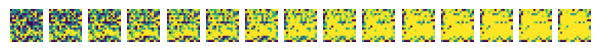

Epoch 0 | Step 100 | Loss: 0.1671963632106781 | C: Trouser


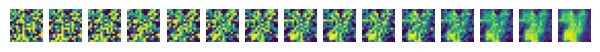

Epoch 0 | Step 200 | Loss: 0.1376439779996872 | C: Pullover


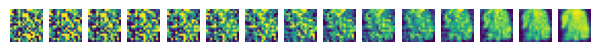

Epoch 0 | Step 300 | Loss: 0.14112567901611328 | C: Dress


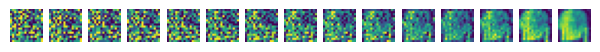

Epoch 0 | Step 400 | Loss: 0.09717852622270584 | C: Coat


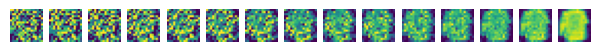

Epoch 0 | Step 500 | Loss: 0.10822538286447525 | C: Sandal


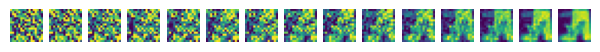

In [10]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1 #3
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = ddpm.get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            class_name = class_names[preview_c]
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {class_name}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES

How did it do? Try running the code cell below to see the final result for each class.

Top


<Figure size 800x800 with 0 Axes>

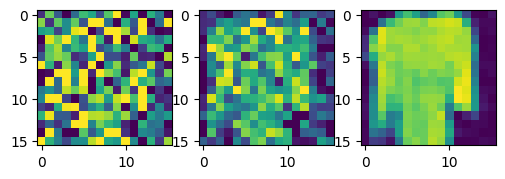

Trouser


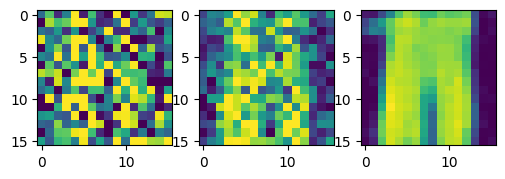

Pullover


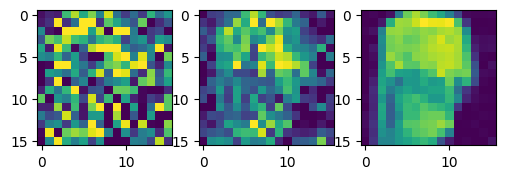

Dress


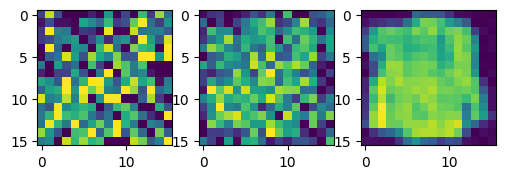

Coat


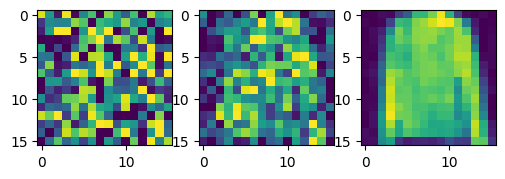

Sandal


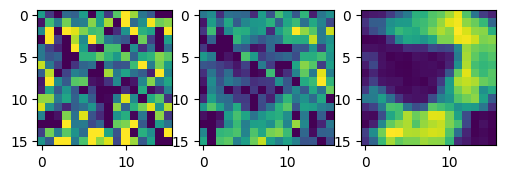

Shirt


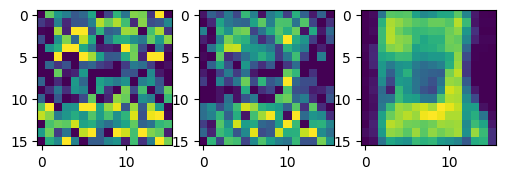

Sneaker


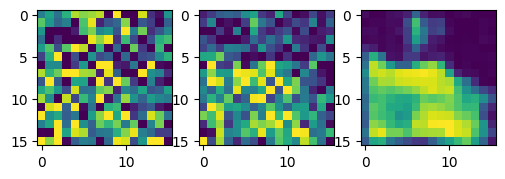

Bag


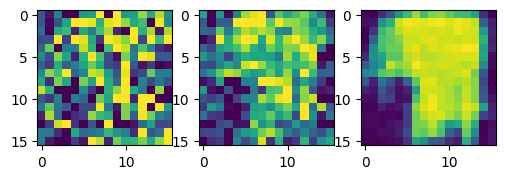

Ankle boot


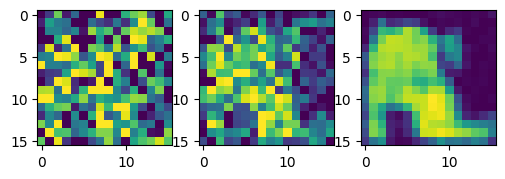

In [11]:
plt.figure(figsize=(8,8))
ncols = 3
c_drop_prob = 0 # Change me to a value between 1 and 0

for c in range(10):
    print(class_names[c])
    c_hot, c_mask = get_context_mask(torch.Tensor([c]), c_drop_prob)
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask, axis_on=True)

## 5.2 Conditioning Reverse Diffusion

Not bad, but not great either. Some of the classes are still influencing each other. For example, this shoe seems to have a shirt sleeve hanging off it.

<center><img src="images/shirt_shoe.png" alt="shirt_shoe" style="width: 400px;"/></center>

We can fix this by increasing the "weight" of the category. Here's the strategy:

* During the reverse diffusion process at each timestep, we will denoise the image **twice**

  * The first noise image we extract will **keep** its classifier information (`e_t_keep_c`)
  * The second noise image we extract will **drop** its classifier information (`e_t_drop_c`)
* We will subtract the average noise from the categorical noise using:

  * `e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c`
  * where `w` is a weight value we choose as a hyperparameter
* We will use this new `e_t` noise to perform diffusion with `reverse_q`.
* Repeat the above steps from `t = T` to `0`.

<center><img src="images/weighted_reverse_diffusion.png"/></center>

We've defined these steps in `sample_w` below. `sample_w` takes a list of noise weights so we can compare how it impacts the diffusion results.

In [12]:
@torch.no_grad()
def sample_w(
    model, input_size, T, c, w_tests=[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0], store_freq=10
):
    # Preprase "grid of samples" with w for rows and c for columns
    n_samples = len(w_tests) * len(c)

    # One w for each c
    w = torch.tensor(w_tests).float().repeat_interleave(len(c))
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w_tests), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).float().to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).float().to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t, c, c_mask)
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = ddpm.reverse_q(x_t, t, e_t)

        # Store values for animation
        if i % store_freq == 0 or i == T or i < 10:
            x_t_store.append(x_t)

    x_t_store = torch.stack(x_t_store)
    return x_t, x_t_store

In [13]:
def save_animation(frames, gif_name, interval=300, repeat_delay=5000):
    fig, ax = plt.subplots()
    ax.axis("off")
    imgs = [[ax.imshow(frame, animated=True)] for frame in frames]

    animate = animation.ArtistAnimation(
        fig, imgs,
        interval=interval, repeat_delay=repeat_delay, blit=False)
    animate.save(gif_name)
    plt.close()

def to_image(tensor, to_pil=True):
    tensor = (tensor + 1) / 2
    # Clamp to [0, 1] using min and max stacks
    # we may directly use the torch.clamp(tensor, 0, 1)
    ones = torch.ones_like(tensor)
    tensor = torch.min(torch.stack([tensor, ones]), 0)[0]
    zeros = torch.zeros_like(tensor)
    tensor = torch.max(torch.stack([tensor, zeros]), 0)[0]
    if not to_pil:
        return tensor
    return transforms.functional.to_pil_image(tensor)

Time to see it in action! Run the code below generate some articles of clothing and arrange them into a grid with [make_grid](https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html).

In [14]:
c = torch.arange(N_CLASSES).to(device)
c_drop_prob = 0  # Keep all category information for sampling
c_hot, c_mask = get_context_mask(c, c_drop_prob)
input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)

x_0, x_t_store = sample_w(model, input_size, T, c_hot)

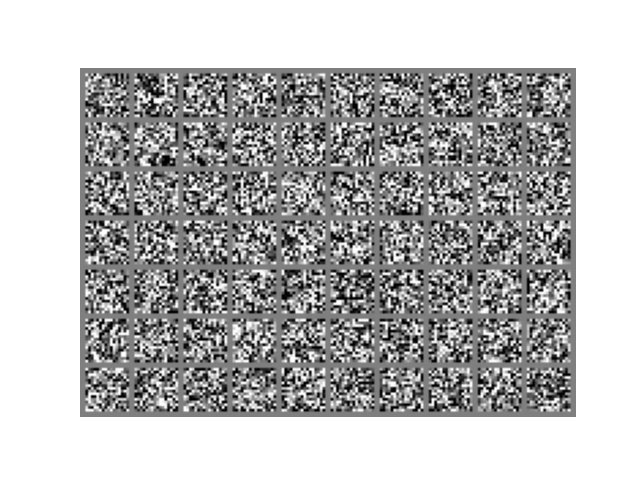

In [15]:
grids = [to_image(make_grid(x_t.cpu(), nrow=N_CLASSES)) for x_t in x_t_store]
save_animation(grids, "04_images/fashionMNIST.gif")
ImageDisplay(open("04_images/fashionMNIST.gif",'rb').read())

Click [here](04_images/fashionMNIST.gif) to see the animation of the reverse diffusion process that was just generated.

The rows represent increasing `w` values from `[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]`. The first two rows are negative, meaning it stresses the average value of the model more than the categorical value. The model will sometimes generate completely different articles of clothing than was intended. The last few rows are consistent in generating items that match their label.

## 5.3 Modified TF Flowers

Congratulations on getting this far! You've mastered FashionMNIST, so now it's time for a bigger challenge: color images. For this challenge, we'll be using a modified version of the [TF Flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset.

These images have been slightly modified for the purpose of image generation. For example, this photo by user "_e.t" has been cropped to focus on the flower.

<center>
    <img src="images/24459750_eb49f6e4cb_m.jpg";/>
    <img src="data/cropped_flowers/sunflowers/24459750_eb49f6e4cb_m.jpg";/>
</center>

**References**
* [TF Flowers - tensorflow](https://www.tensorflow.org/datasets/catalog/tf_flowers)

The model will take much longer to train because of this extra dimension of color. To speed things up, let's preload the images onto the GPU. If we [resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) them before loading them onto our GPU, they will not take up much space.

We can use this technique because the dataset is relatively small. With a larger dataset, this may not be feasible to do.

To start, we should define the dataset variables:
* Image width and height `IMG_SIZE`
* Number of image channels `IMG_CH`
* Batch size `BATCH_SIZE`
* The size of the generated image `INPUT_SIZE`

In [16]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

In order to store the images on the GPU, we will have a list of `pre_transforms` that will run one time when we initialize our dataset. Then, the `random_transforms` will run on each batch when it is pulled from the dataset.

[Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) will resize an image so that the smaller edge between the width and height matches the size we specify. Then, we can use [RandomCrop](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html) to both make the image square and effectively increase the size of our dataset with random data augmentation.

**References**
* [RandomCrop - pytorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html)
* [Resize - Pytorch docs](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html)

In [17]:
import torchvision
from torch.utils.data import Dataset, DataLoader

pre_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

Next, let's develop a function to read in the image files. We'll use each image's parent directly to identify its label. We have three categories listed in `DATA_LABELS` below.

<center>
    <img src="data/cropped_flowers/daisy/14219214466_3ca6104eae_m.jpg";/>
    <img src="data/cropped_flowers/sunflowers/1240625276_fb3bd0c7b1.jpg";/>
    <img src="data/cropped_flowers/roses/14510185271_b5d75dd98e_n.jpg";/>
</center>

From left to right, we have a `daisy` by Allison Brown, a `sunflower` by Rob Young, and a `rose` by Matteo Accattino. The author for each photo is listed in [LICENSE.txt](data/cropped_flowers/LICENSE.txt)

Let's use the [glob](https://docs.python.org/3/library/glob.html) function to programmatically fetch the datapaths for each flower photo.

In [21]:
## Dataset is heavy. So mounting to drive use the dataset
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
DATA_DIR = "data/cropped_flowers/"
DATA_LABELS = ["daisy", "sunflowers", "roses"]
N_CLASSES = len(DATA_LABELS)

data_paths = glob.glob(DATA_DIR + DATA_LABELS[0] + '/*.jpg', recursive=True)
data_paths[:5]  # First 5 paths

['/content/drive/MyDrive/data/cropped_flowers/daisy/12348343085_d4c396e5b5_m.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/daisy/2877860110_a842f8b14a_m.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/daisy/2365428551_39f83f10bf_n.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/daisy/5626895440_97a0ec04c2_n.jpg',
 '/content/drive/MyDrive/data/cropped_flowers/daisy/14716799982_ed6d626a66.jpg']

We can use pytorch's [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) tools in order to create our own dataset. `__init__` will run once when the class is initialized. `__getitem__` returns our images and labels while randomly applying our `random_transforms`.

In [23]:
class MyDataset(Dataset):
    def __init__(self):
        self.imgs = []
        self.labels = []

        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(DATA_DIR + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_transforms(img).to(device))
                self.labels.append(l_idx)


    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

train_data = MyDataset()
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Time to initialize our U-Net. It's the same as before, but our `T` is much larger as are our `down_chs`.

In [24]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = DDPM(B, device)

In [25]:
model_flowers = UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model_flowers.parameters()))
model_flowers = torch.compile(model_flowers.to(device))

Num params:  44509443


Let's create a function to sample our diffusion model, so we can generate images during and after training.

In [26]:
def sample_flowers(n_classes):
    c_test = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c_test, 0)
    x_gen, x_gen_store = sample_w(model_flowers, INPUT_SIZE, T, c_hot_test)
    return x_gen, x_gen_store

In [27]:
def train_flowers(dataloader, epochs=100, n_classes=N_CLASSES, c_drop_prob=0.1, save_dir = "04_images/"):
    lrate = 1e-4
    optimizer = torch.optim.Adam(model_flowers.parameters(), lr=lrate)

    c = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c, 0)

    model_flowers.train()
    for epoch in range(epochs):
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x = batch[0].to(device)
            c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)
            loss = ddpm.get_loss(model_flowers, x, t, c_hot, c_mask)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            x_gen, x_gen_store = sample_flowers(n_classes)
            grid = make_grid(x_gen.cpu(), nrow=n_classes)
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")

Moment of truth! Let's see how the diffusion model handles color images. The model will take about **fifteen minutes** to train. Once it starts training, grab a coffee, tea, or cozy beverage of choice. Then, check out the test outputs in the `04_images` directory. Flowers are recognizable at epoch 50, and the model will really hit its stride at epoch 100. It's fun to watch it learn.

In [28]:
train_flowers(dataloader)

Epoch 0 | Step 008 | Loss: 0.5269721746444702
saved images in 04_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.23389312624931335
Epoch 2 | Step 008 | Loss: 0.20773637294769287
Epoch 3 | Step 008 | Loss: 0.17765246331691742
Epoch 4 | Step 008 | Loss: 0.13923466205596924
Epoch 5 | Step 008 | Loss: 0.1871061623096466
saved images in 04_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.16682136058807373
Epoch 7 | Step 008 | Loss: 0.15510177612304688
Epoch 8 | Step 008 | Loss: 0.14921638369560242
Epoch 9 | Step 008 | Loss: 0.15970797836780548
Epoch 10 | Step 008 | Loss: 0.14179305732250214
saved images in 04_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.11591404676437378
Epoch 12 | Step 008 | Loss: 0.11487250030040741
Epoch 13 | Step 008 | Loss: 0.14018037915229797
Epoch 14 | Step 008 | Loss: 0.10709623992443085
Epoch 15 | Step 008 | Loss: 0.13774071633815765
saved images in 04_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.10839974880218506
Epoch 17 | Step 008 | Loss: 0.

Due to the random nature of diffusion models, some images will appear better than others. Try resampling until there is an output you'd like to keep as a souvenir. Then, run the cell afterwards to turn it into an animation.

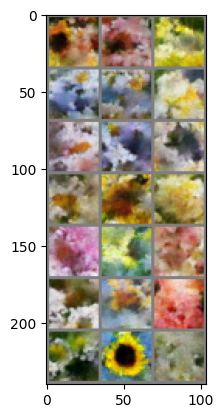

In [30]:
model.eval()
x_gen, x_gen_store = sample_flowers(N_CLASSES)
grid = make_grid(x_gen.cpu(), nrow=N_CLASSES)
show_tensor_image([grid])
plt.show()

In [31]:
grids = [to_image(make_grid(x_gen.cpu(), nrow=N_CLASSES)) for x_gen in x_gen_store]
save_animation(grids, "04_images/flowers.gif")

## 5.4 Next

Not bad for a few minutes of training! In the next notebook, we'll make the results even better with a full text-to-image pipeline.

In [32]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}